# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](./neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39は[matplotlib](http://matplotlib.org/)もしくは[Gnuplot](http://www.gnuplot.info/)を用いるとよい．

In [30]:
import MeCab
tagger = MeCab.Tagger()
print(tagger.parse("吾輩は猫である。"))

吾輩	ワガハイ	ワガハイ	我が輩	代名詞			0
は	ワ	ハ	は	助詞-係助詞			
猫	ネコ	ネコ	猫	名詞-普通名詞-一般			1
で	デ	ダ	だ	助動詞	助動詞-ダ	連用形-一般	
ある	アル	アル	有る	動詞-非自立可能	五段-ラ行	終止形-一般	1
。			。	補助記号-句点			
EOS



In [31]:
import MeCab

with open("neko.txt", "r") as f:
    lines = f.read().rstrip().split("\n")

tagger = MeCab.Tagger()

result = []
for line in lines:
    result.append(tagger.parse(line))

with open("neko.txt.mecab", "w") as f:
    f.writelines(result)

## 30. 形態素解析結果の読み込み

形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [32]:
with open("neko.txt.mecab", "r") as f:
    lines = f.read().rstrip().split("\n")

POS_list = []
l = []
for line in lines:
    dic = {}
    if(line == "EOS"):
        if(len(l)):
            POS_list.append(l)
        l = []
    else: 
        line = line.split("\t", 5)
        dic["surface"] = line[0]
        dic["base"] = line[3]
        pos = line[4].split("-")
        dic["pos"] = pos[0]
        try:
            dic["pos1"] = pos[1]
        except:
            dic["pos1"] = "*"
        if(dic["pos"] == "空白"):
            continue
        l.append(dic)

from pprint import pprint
pprint(POS_list[:3])

[[{'base': '一', 'pos': '名詞', 'pos1': '数詞', 'surface': '一'}],
 [{'base': '我が輩', 'pos': '代名詞', 'pos1': '*', 'surface': '吾輩'},
  {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
  {'base': '猫', 'pos': '名詞', 'pos1': '普通名詞', 'surface': '猫'},
  {'base': 'だ', 'pos': '助動詞', 'pos1': '*', 'surface': 'で'},
  {'base': '有る', 'pos': '動詞', 'pos1': '非自立可能', 'surface': 'ある'},
  {'base': '。', 'pos': '補助記号', 'pos1': '句点', 'surface': '。'}],
 [{'base': '名前', 'pos': '名詞', 'pos1': '普通名詞', 'surface': '名前'},
  {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
  {'base': '未だ', 'pos': '副詞', 'pos1': '*', 'surface': 'まだ'},
  {'base': '無い', 'pos': '形容詞', 'pos1': '非自立可能', 'surface': '無い'},
  {'base': '。', 'pos': '補助記号', 'pos1': '句点', 'surface': '。'}]]


## 31. 動詞
動詞の表層形をすべて抽出せよ．

In [33]:
verb_surface_set = set()
for poss in POS_list:
    for pos in poss:
        if(pos["pos"] == "動詞"):
            verb_surface_set.add(pos["surface"])
pprint(list(verb_surface_set)[:10])

['卒え', '廻れ', 'つとめ', '終え', '激し', '限っ', '留め', '叫び', '跳ね返し', '切る']


## 32. 動詞の基本形
動詞の基本形をすべて抽出せよ．

In [34]:
verb_base_set = set()
for poss in POS_list:
    for pos in poss:
        if(pos["pos"] == "動詞"):
            verb_base_set.add(pos["base"])
pprint(list(verb_base_set)[:10])

['刺し通す', '了する', '放り出す', '燻る', '切る', '唱える', '教える', '濡れる', '思い込む', '追い遣る']


## 33. 「AのB」
2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [35]:
B_of_A = list()
for poss in POS_list:
    for i, pos in enumerate(poss):
        if(i == 0 or i == len(poss) - 1):
            continue
        if(pos["surface"] == "の" and pos["pos1"] == "格助詞"):
            if(poss[i-1]["pos"] == "名詞" and poss[i+1]["pos"] == "名詞"):
                B_of_A.append(poss[i-1]["surface"] + pos["surface"] + poss[i+1]["surface"])
pprint(B_of_A[:10])

['掌の上', '書生の顔', 'ものの見', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '掌の裏', '藁の上', '笹原の中']


## 34. 名詞の連接
名詞の連接（連続して出現する名詞）を最長一致で抽出せよ．

In [36]:
nouns = []
all_pos_list = []
for poss in POS_list:
    for pos in poss:
        all_pos_list.append(pos)
for i, pos in enumerate(all_pos_list):
    if(pos["pos"] == "名詞"):
        nouns.append([i, pos["surface"]])

result = []
flag = [False] * len(nouns)
for i in range(len(nouns) - 1):
    if(flag[i]):
        continue
    flag[i] = True
    l = [nouns[i][1]]
    j = i + 1
    idx = nouns[i][0]
    while(j < len(nouns) and nouns[j][0] == idx + 1):
        l.append(nouns[j][1])
        idx = nouns[j][0]
        flag[j] = True
        j += 1
    if(len(l) > 1):
        result.append(l)

for i in range(len(result)):
    result[i] = "".join(result[i])

pprint(result[:10])

['見始', '時妙', '一毛', '後猫', '一度', '上今', 'うち池', '書生以外', '間おさん', '宿なし']


## 35. 単語の出現頻度
文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [37]:
from collections import defaultdict
d = defaultdict(int)

for pos in all_pos_list:
    d[pos["surface"]] += 1

sorted_d = sorted(d.items(), key=lambda x:x[1], reverse=True)
for i in range(len(sorted_d)):
    sorted_d[i] = list(sorted_d[i])
pprint(sorted_d[:10])

[['の', 9541],
 ['。', 7486],
 ['て', 7418],
 ['に', 7060],
 ['、', 6773],
 ['は', 6501],
 ['と', 6156],
 ['を', 6119],
 ['が', 5394],
 ['で', 4543]]


## 36. 頻度上位10語
出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


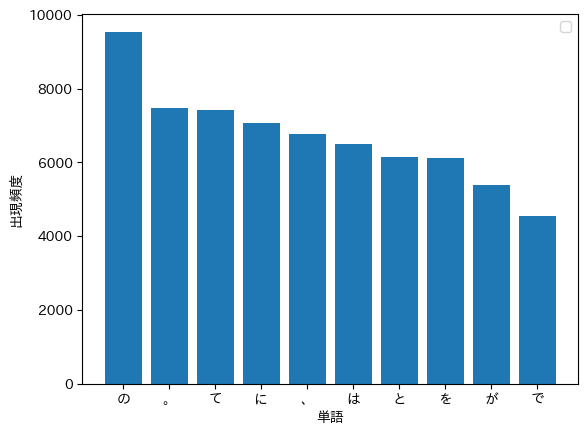

In [38]:
import matplotlib.pyplot as plt
import japanize_matplotlib

top10 = sorted_d[:10]
x = [item[0] for item in top10]
y = [item[1] for item in top10]

plt.bar(x, y)
plt.xlabel("単語")
plt.ylabel("出現頻度")
plt.legend()
plt.show()

## 37. 「猫」と共起頻度の高い上位10語
「猫」とよく共起する（共起頻度が高い）10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

In [39]:
word_set = []
for line in POS_list:
    line = [item for item in line if item["pos"] not in ["補助記号", "助詞", "助動詞"]]
    l = [item["surface"] for item in line]
    if("猫" in l):
        word_set.append(set(l))

import pyfpgrowth
patterns = pyfpgrowth.find_frequent_patterns(word_set, 30)
sorted_patterns = sorted(patterns.items(),reverse=True,key=lambda x:x[1])
result = []
neko_num = sorted_patterns[0][1]
for item in sorted_patterns:
    if(len(item[0]) == 2 and "猫" in item[0]):
        result.append([list(item[0]), item[1]])
pprint(result)

[[['ある', '猫'], 83],
 [['し', '猫'], 77],
 [['吾輩', '猫'], 53],
 [['ない', '猫'], 49],
 [['事', '猫'], 45],
 [['いる', '猫'], 37],
 [['人間', '猫'], 34],
 [['する', '猫'], 31],
 [['この', '猫'], 30]]


['猫', 'ある', 'し', '吾輩', 'ない', '事', 'いる', '人間', 'する', 'この'] [211, 83, 77, 53, 49, 45, 37, 34, 31, 30]


<BarContainer object of 10 artists>

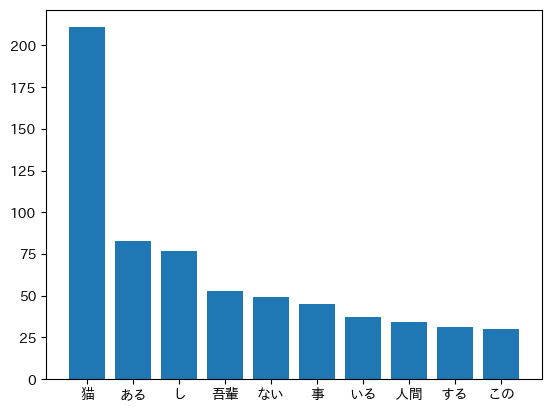

In [40]:
x = ["猫"]
x.extend([item[0][0] for item in result])
y = [neko_num]
y.extend([item[1] for item in result])
print(x, y)
plt.bar(x, y)


## 38. ヒストグラム
単語の出現頻度のヒストグラムを描け．ただし，横軸は出現頻度を表し，1から単語の出現頻度の最大値までの線形目盛とする．縦軸はx軸で示される出現頻度となった単語の異なり数（種類数）である．


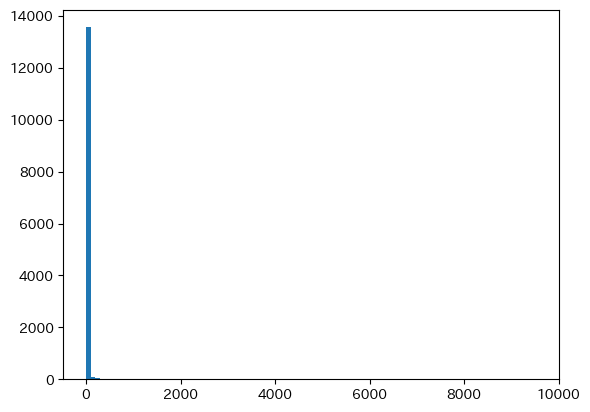

In [41]:
freqs = [item[1] for item in sorted_d]

plt.hist(freqs, bins=100)
plt.show()


## 39. Zipfの法則
単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

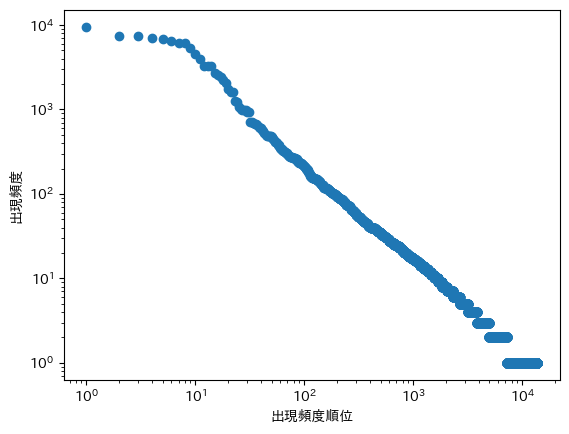

In [42]:
plt.scatter(range(1, len(freqs) + 1), freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("出現頻度順位")
plt.ylabel("出現頻度")
plt.show()